# 1. Постановка задачи

В данной работе рассматривается решение задачи классификации для датасета, собранного на основе данных CSPC2018. Этот датасет описывает характеристики пациентов с подозрением на одно из сердечных заболеваний. Среди данных представлены пол, возраст пациентов, а также различные данные, снятые с сигналов их кардиограммы. Итоговый класс - f_label - обозначает диагноз: 0 - пациент здоров, 1-9 - пациент болен одним из сердечных заболеваний.

In [1]:
from __future__ import division, print_function, unicode_literals

import sys
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
import IPython as IPy
import sklearn as skl
import seaborn as sns
from sklearn.model_selection import train_test_split

import os
import tarfile
import urllib
import pickle

import joblib

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
def save_obj(obj, name):
    os.makedirs("obj", exist_ok=True)
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

# 2. Обработка данных

## 2.1. Общая информация

In [3]:
data = pd.read_csv('datasets/cspc2018.csv', index_col = [0])
data

,Qrst_dur,P_Q_duration,Q_T_duration,T_duration,P_duration,Heart_rate_mean,f_label,sex,age,QRSA,Q_av,R_av,S_av,Heart_rate_std
0,0.076632,NaN,0.279263,0.123100,NaN,171.184023,5,0,74,-596.758874,3.616371,1864.425542,1860.809172,1.044164
1,0.107158,NaN,0.298000,0.112200,NaN,187.826087,1,0,74,-790.003412,5.422741,1844.263848,1838.841108,7.288161
2,0.082800,NaN,0.284947,0.108200,NaN,186.244078,2,0,74,-230.210919,10.927699,1840.033096,1829.105397,32.961007
3,0.081500,NaN,0.314706,0.142556,NaN,185.546875,2,0,74,685.091725,3.258911,1846.318812,1843.059901,33.344774
4,0.075053,NaN,0.268421,0.084762,NaN,170.239596,7,0,74,-214.589496,3.348546,1880.346540,1876.997994,1.757699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,0.104125,0.0,0.376000,0.153500,0.071875,75.942958,0,1,61,31.864414,4.296980,2247.126398,2242.829418,27.559915
23996,0.100500,0.0,0.413750,0.193625,0.080750,75.598488,0,1,61,-34.948739,4.186152,2250.085698,2245.899546,27.457037
23997,0.094750,0.0,0.420625,0.190500,0.087500,75.062552,0,1,61,-98.447443,5.704861,2250.611111,2244.906250,27.379838
23998,0.091500,0.0,0.416125,0.178625,0.093750,74.775673,0,1,61,-111.225219,5.864009,2255.627784,2249.763775,27.642841


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24000 entries, 0 to 23999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Qrst_dur         23992 non-null  float64
 1   P_Q_duration     20897 non-null  float64
 2   Q_T_duration     23986 non-null  float64
 3   T_duration       23987 non-null  float64
 4   P_duration       20918 non-null  float64
 5   Heart_rate_mean  23990 non-null  float64
 6   f_label          24000 non-null  int64  
 7   sex              24000 non-null  int64  
 8   age              24000 non-null  int64  
 9   QRSA             24000 non-null  float64
 10  Q_av             23992 non-null  float64
 11  R_av             23992 non-null  float64
 12  S_av             23992 non-null  float64
 13  Heart_rate_std   23990 non-null  float64
dtypes: float64(11), int64(3)
memory usage: 2.7 MB


In [5]:
data.describe()

,Qrst_dur,P_Q_duration,Q_T_duration,T_duration,P_duration,Heart_rate_mean,f_label,sex,age,QRSA,Q_av,R_av,S_av,Heart_rate_std
count,23992.000000,20897.000000,23986.000000,23987.000000,20918.000000,23990.000000,24000.000000,24000.000000,24000.000000,24000.000000,23992.000000,23992.000000,23992.000000,23990.000000
mean,0.095190,0.151331,0.369847,0.166779,0.082934,93.838344,1.290417,0.476000,60.691000,-57.853812,4.749327,2004.186276,1999.436949,37.211082
std,0.016898,0.030137,0.043924,0.033447,0.018067,28.200401,2.408852,0.499434,19.247102,1146.449992,2.188224,1223.274911,1223.267296,49.258580
min,0.016000,0.000000,0.068000,0.019143,0.000000,10.456605,0.000000,0.000000,0.000000,-28876.511706,0.937500,762.147222,758.550000,0.000000
25%,0.084218,0.130667,0.341579,0.143167,0.071778,75.228843,0.000000,0.000000,49.000000,-271.941880,3.381630,1288.341788,1283.091698,7.614010
50%,0.091407,0.147111,0.370000,0.168100,0.084000,87.603906,0.000000,0.000000,64.000000,2.244833,4.165359,1541.834174,1536.649410,16.673585
75%,0.101429,0.167600,0.397035,0.190667,0.095619,105.351184,1.000000,1.000000,76.000000,217.193793,5.454890,2185.013350,2180.349569,56.129288
max,0.206600,0.400000,1.070000,0.293429,0.145867,324.143070,9.000000,1.000000,104.000000,53174.812387,28.421053,16651.059880,16645.205362,1575.621672


Видим, что некоторые столбцы имеют неприлично большой разброс. С ними следует поработать.

In [6]:
data.isna().sum()

Qrst_dur              8
P_Q_duration       3103
Q_T_duration         14
T_duration           13
P_duration         3082
Heart_rate_mean      10
f_label               0
sex                   0
age                   0
QRSA                  0
Q_av                  8
R_av                  8
S_av                  8
Heart_rate_std       10
dtype: int64

Поскольку пропущены числовые признаки, и адекватно восстановить их не получается, то один из вариантов - заполнить их медианой.

In [7]:
plt.figure(figsize=(15,10))

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

## 2.1. Корреляция

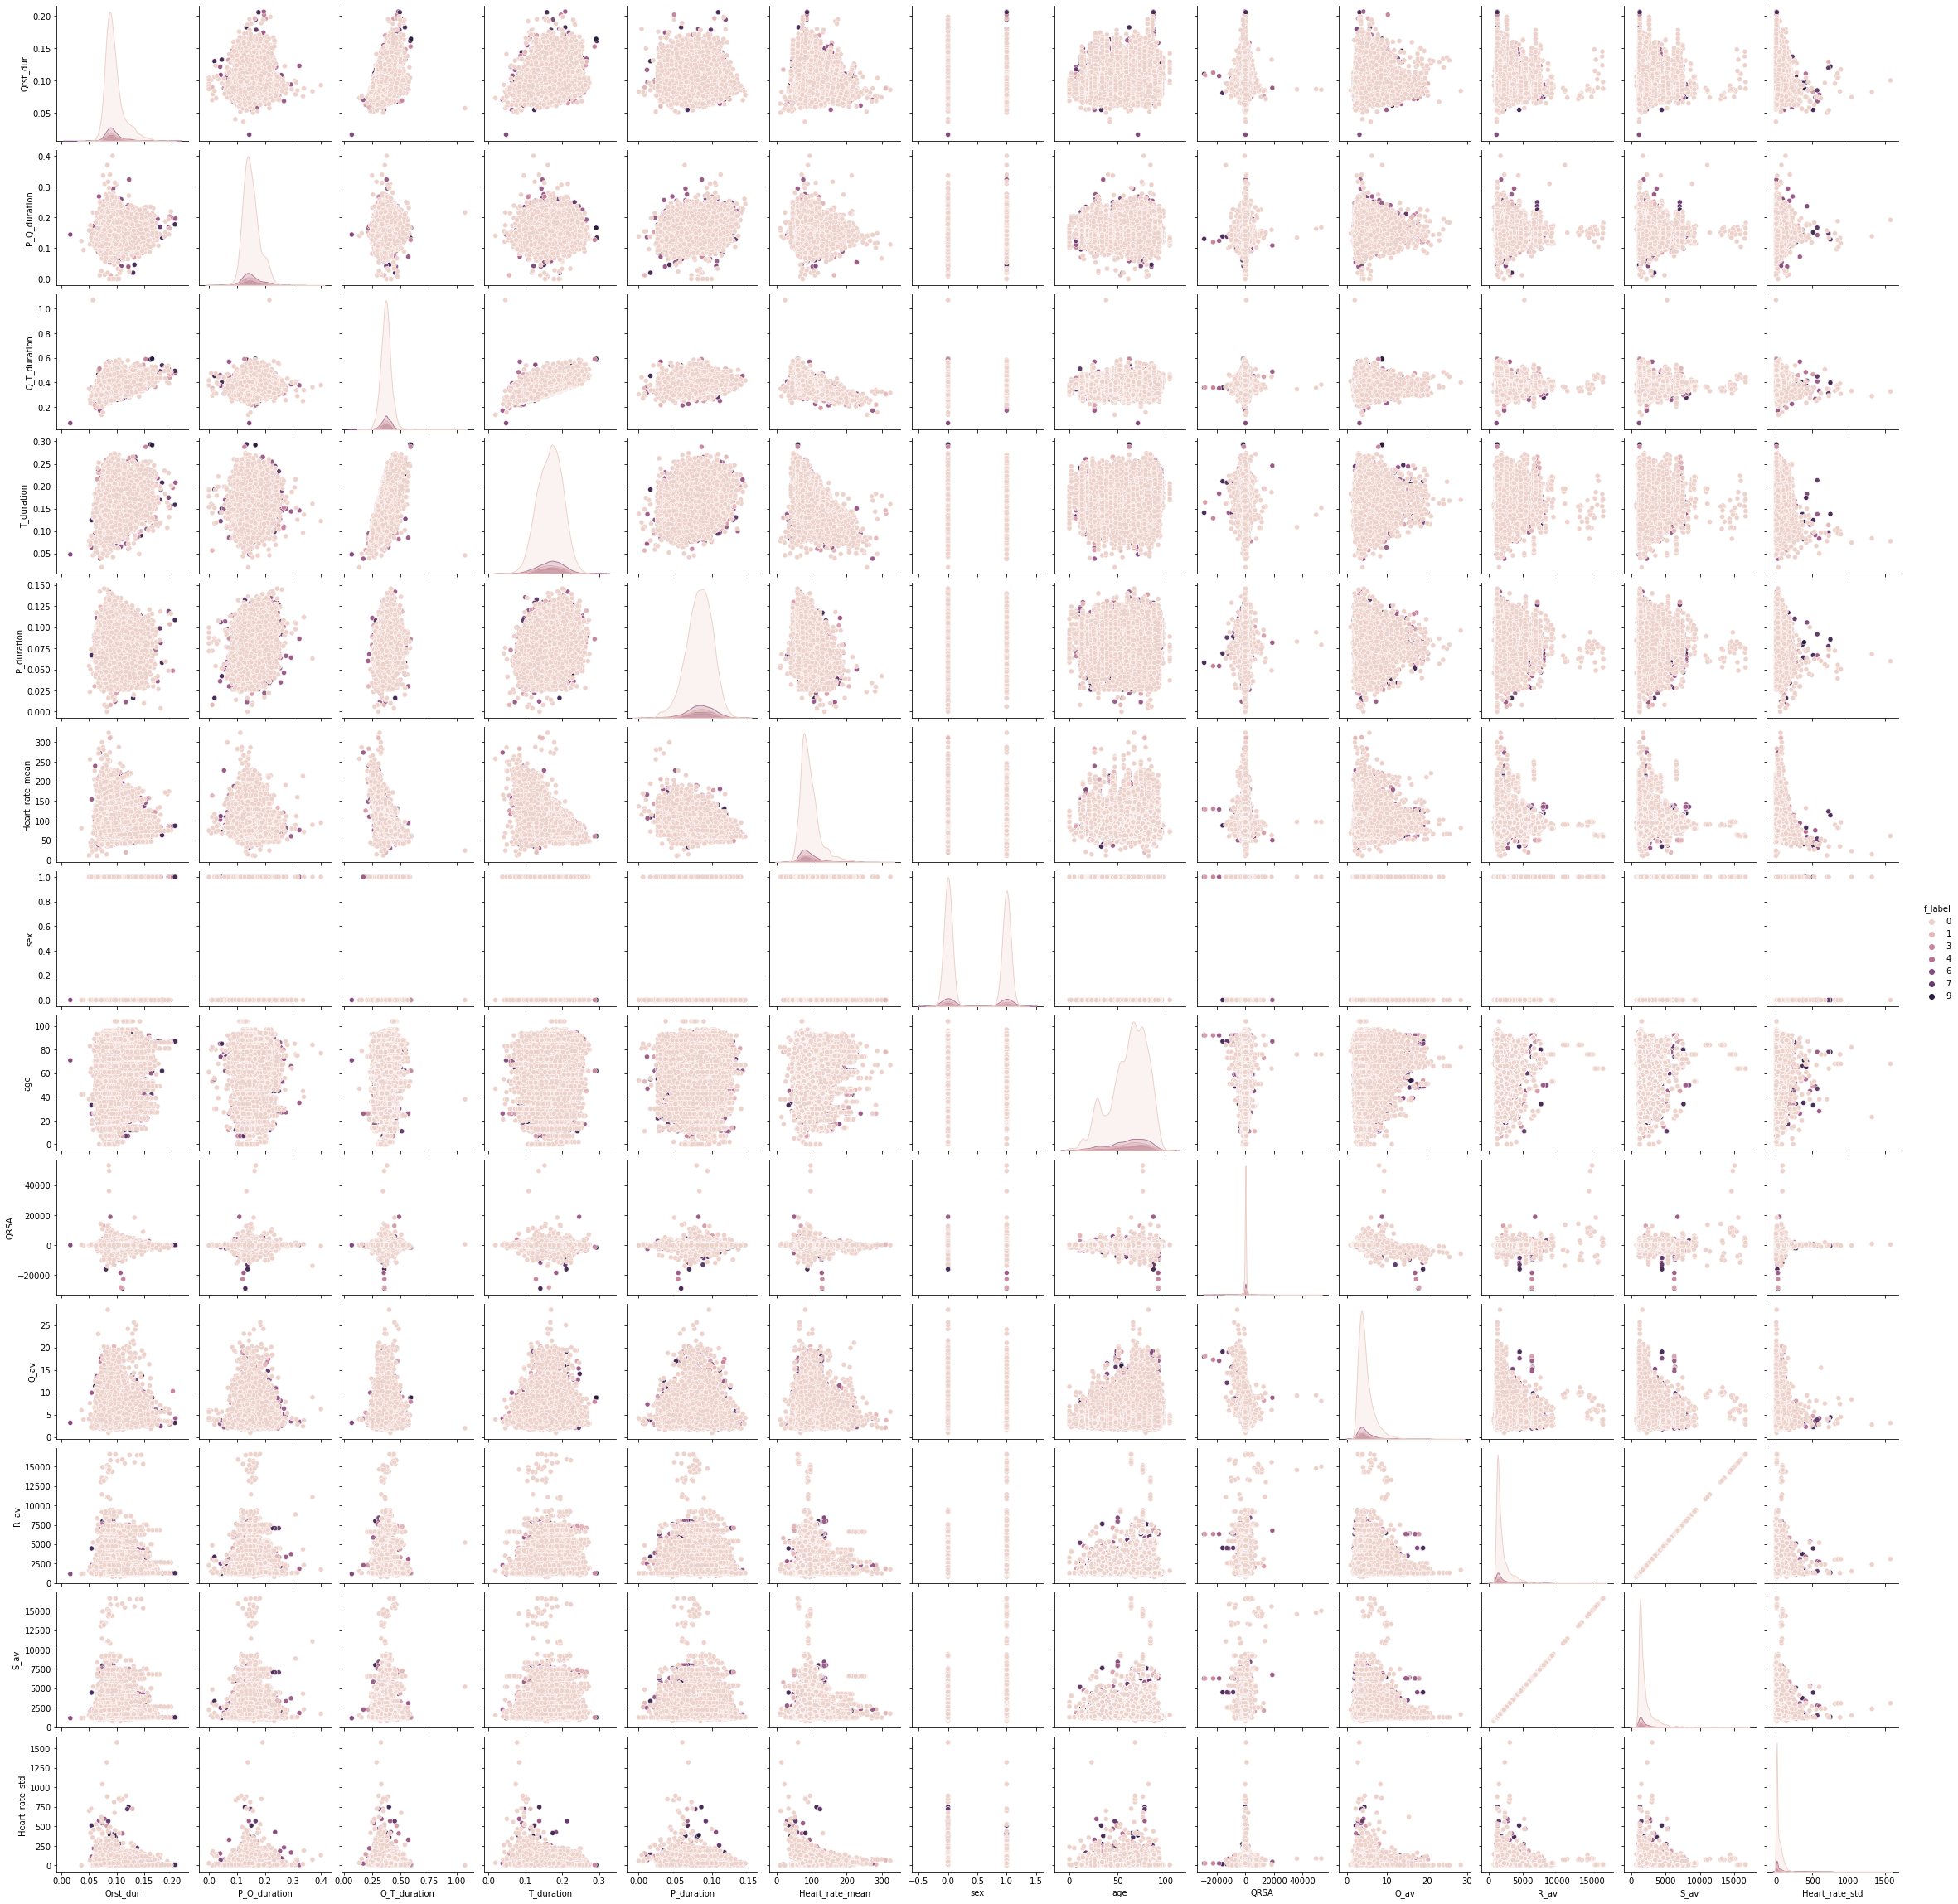

In [8]:
sns.pairplot(data, hue='f_label')

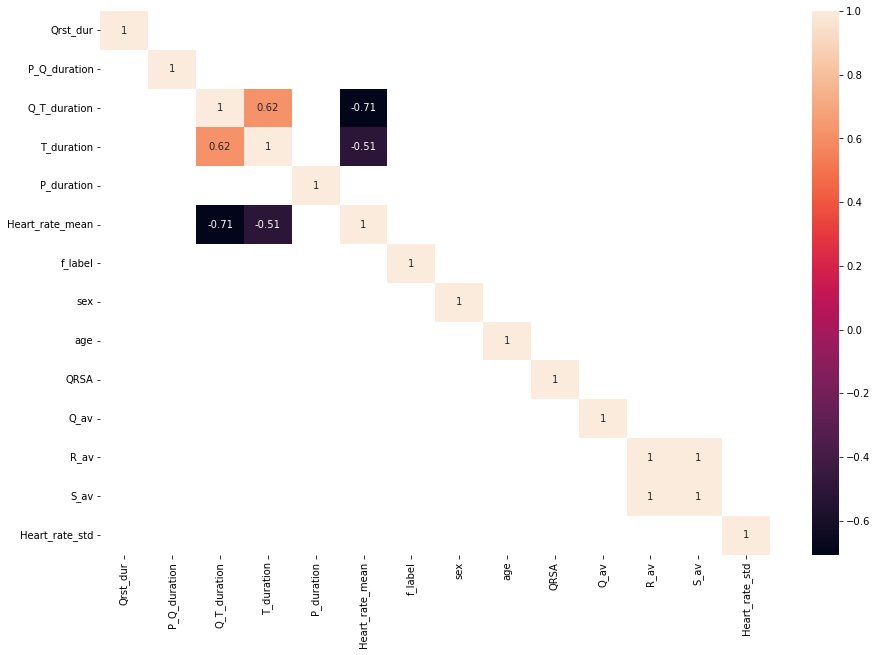

In [9]:
plt.figure(figsize=(15,10))
ax = sns.heatmap(data.corr()[abs(data.corr())>=0.4] , annot=True)

Видим, что признаки S_av и R_av скоррелированы слишком сильно. Скорее всего, это означает, что на самом деле они характеризуют одно и то же. Поэтому от одного из них можно избавиться. Остальные пока оставим.

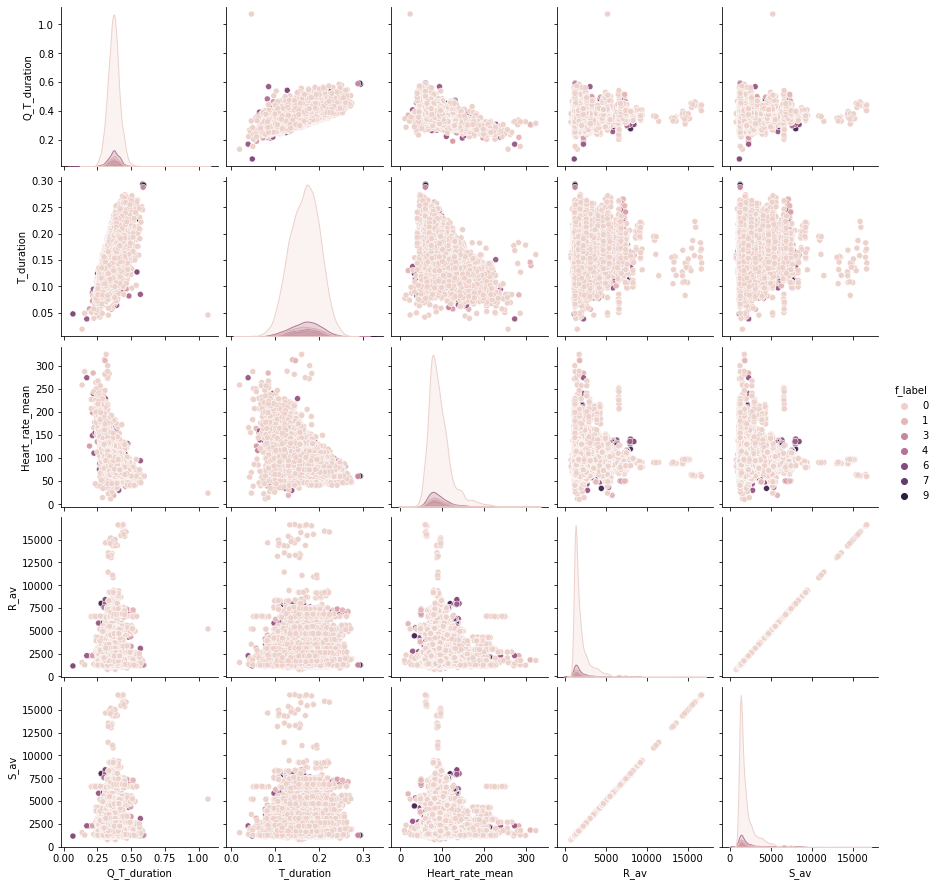

In [10]:
sns.pairplot(data[['Q_T_duration', 'T_duration', 'Heart_rate_mean', 'R_av', 'S_av', 'f_label']], hue='f_label')

In [11]:
data.drop('S_av', axis=1, inplace=True)

In [12]:
data.isna().sum()

Qrst_dur              8
P_Q_duration       3103
Q_T_duration         14
T_duration           13
P_duration         3082
Heart_rate_mean      10
f_label               0
sex                   0
age                   0
QRSA                  0
Q_av                  8
R_av                  8
Heart_rate_std       10
dtype: int64

## 2.3. Обработка выбросов

In [13]:
data.describe()

,Qrst_dur,P_Q_duration,Q_T_duration,T_duration,P_duration,Heart_rate_mean,f_label,sex,age,QRSA,Q_av,R_av,Heart_rate_std
count,23992.000000,20897.000000,23986.000000,23987.000000,20918.000000,23990.000000,24000.000000,24000.000000,24000.000000,24000.000000,23992.000000,23992.000000,23990.000000
mean,0.095190,0.151331,0.369847,0.166779,0.082934,93.838344,1.290417,0.476000,60.691000,-57.853812,4.749327,2004.186276,37.211082
std,0.016898,0.030137,0.043924,0.033447,0.018067,28.200401,2.408852,0.499434,19.247102,1146.449992,2.188224,1223.274911,49.258580
min,0.016000,0.000000,0.068000,0.019143,0.000000,10.456605,0.000000,0.000000,0.000000,-28876.511706,0.937500,762.147222,0.000000
25%,0.084218,0.130667,0.341579,0.143167,0.071778,75.228843,0.000000,0.000000,49.000000,-271.941880,3.381630,1288.341788,7.614010
50%,0.091407,0.147111,0.370000,0.168100,0.084000,87.603906,0.000000,0.000000,64.000000,2.244833,4.165359,1541.834174,16.673585
75%,0.101429,0.167600,0.397035,0.190667,0.095619,105.351184,1.000000,1.000000,76.000000,217.193793,5.454890,2185.013350,56.129288
max,0.206600,0.400000,1.070000,0.293429,0.145867,324.143070,9.000000,1.000000,104.000000,53174.812387,28.421053,16651.059880,1575.621672


In [14]:
Q1 = data['QRSA'].quantile(0.25)
Q3 = data['QRSA'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

filter = (data['QRSA'] < Q1 - 1.5 * IQR) | (data['QRSA'] > Q3 + 1.5 *IQR)
data.loc[filter].index

Int64Index([    6,     7,     9,    10,    11,    43,    67,   114,   120,
              121,
            ...
            23891, 23898, 23899, 23911, 23912, 23935, 23970, 23971, 23972,
            23973],
           dtype='int64', length=2749)

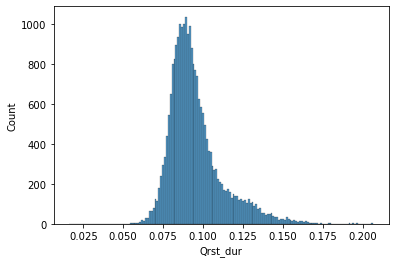

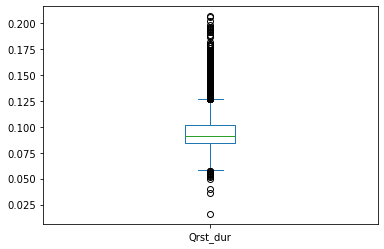

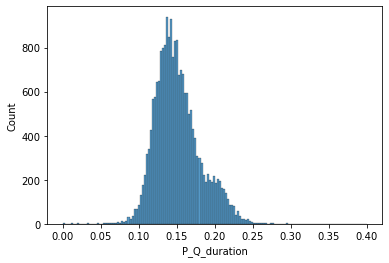

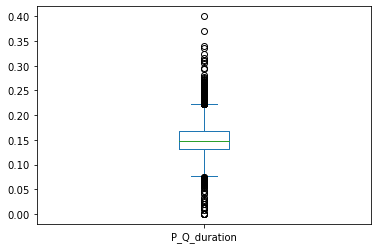

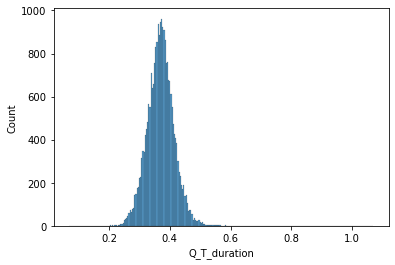

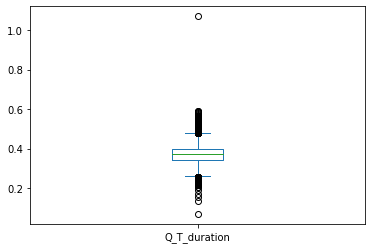

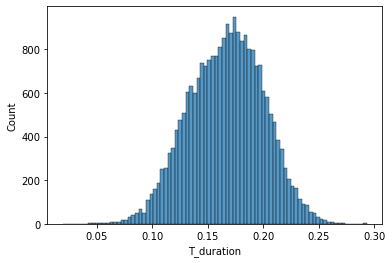

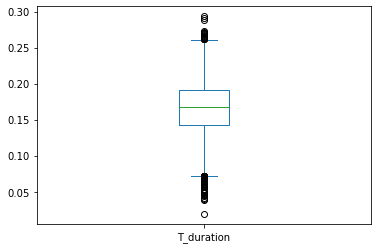

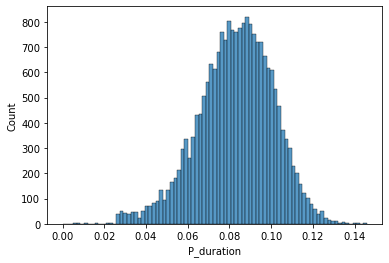

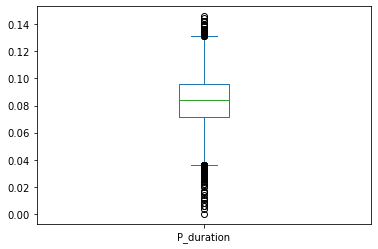

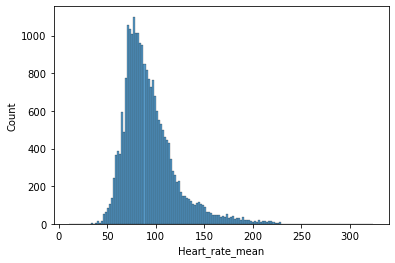

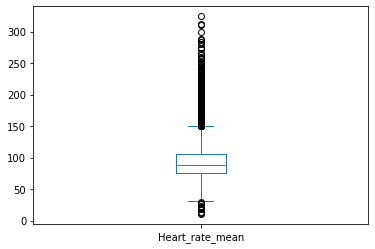

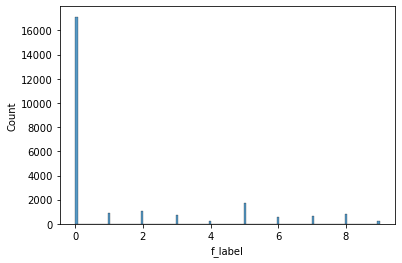

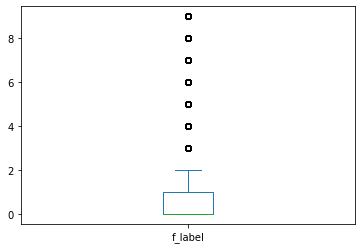

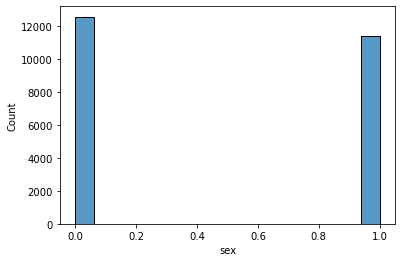

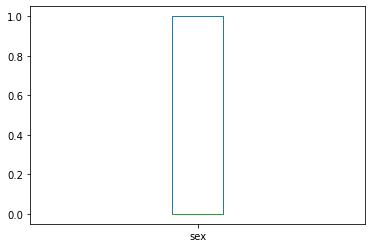

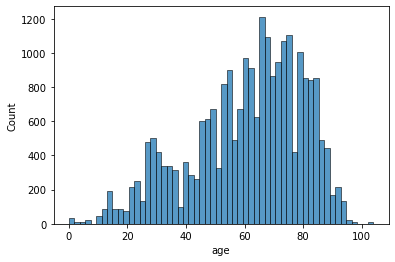

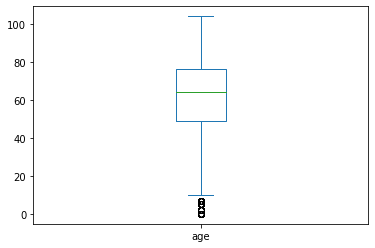

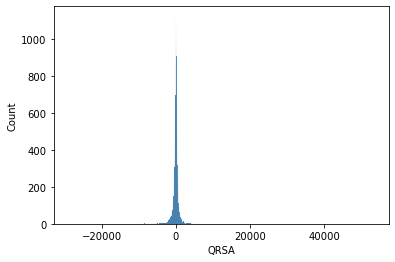

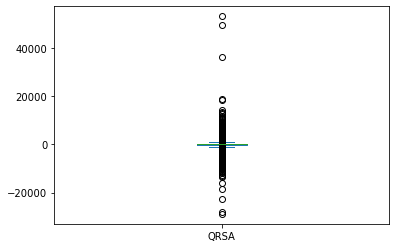

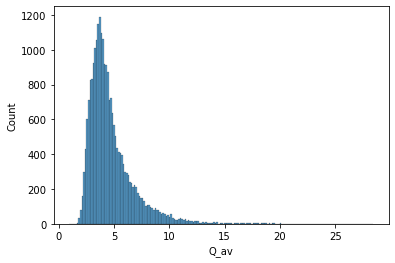

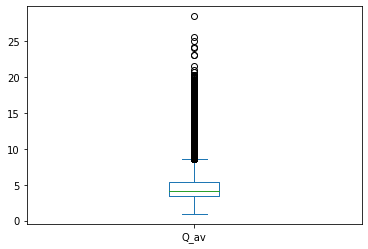

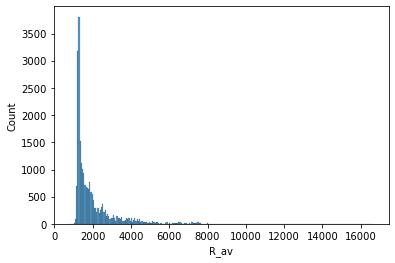

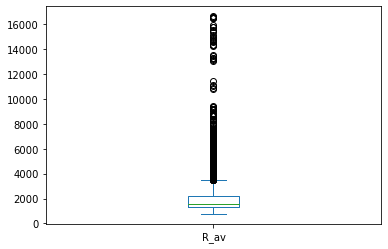

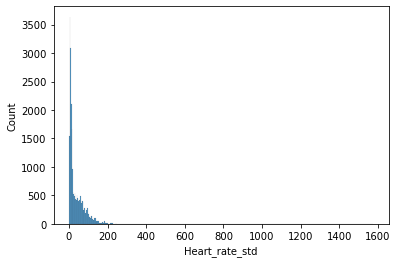

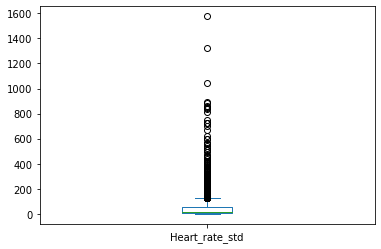

In [15]:
for col in data.columns:
    sns.histplot(data[col])
    plt.show()
    data[col].plot(kind='box')
    plt.show()

Видим, что признаки QRSA, R_av и Heart_rate_std имеют огромное стандартное отклонение. Избавимся от выбросов в них.

In [16]:
ix_set = set()

for col in ['QRSA', 'R_av', 'Heart_rate_std']:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range. 

    filter = (data[col] < Q1 - 1.5 * IQR) | (data[col] > Q3 + 1.5 *IQR)
    ix_set.update(data.loc[filter].index)

In [17]:
data

,Qrst_dur,P_Q_duration,Q_T_duration,T_duration,P_duration,Heart_rate_mean,f_label,sex,age,QRSA,Q_av,R_av,Heart_rate_std
0,0.076632,NaN,0.279263,0.123100,NaN,171.184023,5,0,74,-596.758874,3.616371,1864.425542,1.044164
1,0.107158,NaN,0.298000,0.112200,NaN,187.826087,1,0,74,-790.003412,5.422741,1844.263848,7.288161
2,0.082800,NaN,0.284947,0.108200,NaN,186.244078,2,0,74,-230.210919,10.927699,1840.033096,32.961007
3,0.081500,NaN,0.314706,0.142556,NaN,185.546875,2,0,74,685.091725,3.258911,1846.318812,33.344774
4,0.075053,NaN,0.268421,0.084762,NaN,170.239596,7,0,74,-214.589496,3.348546,1880.346540,1.757699
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,0.104125,0.0,0.376000,0.153500,0.071875,75.942958,0,1,61,31.864414,4.296980,2247.126398,27.559915
23996,0.100500,0.0,0.413750,0.193625,0.080750,75.598488,0,1,61,-34.948739,4.186152,2250.085698,27.457037
23997,0.094750,0.0,0.420625,0.190500,0.087500,75.062552,0,1,61,-98.447443,5.704861,2250.611111,27.379838
23998,0.091500,0.0,0.416125,0.178625,0.093750,74.775673,0,1,61,-111.225219,5.864009,2255.627784,27.642841


In [18]:
data.drop(ix_set, inplace=True)
data.reset_index(drop=True, inplace=True)

In [19]:
data

,Qrst_dur,P_Q_duration,Q_T_duration,T_duration,P_duration,Heart_rate_mean,f_label,sex,age,QRSA,Q_av,R_av,Heart_rate_std
0,0.076632,NaN,0.279263,0.123100,NaN,171.184023,5,0,74,-596.758874,3.616371,1864.425542,1.044164
1,0.107158,NaN,0.298000,0.112200,NaN,187.826087,1,0,74,-790.003412,5.422741,1844.263848,7.288161
2,0.082800,NaN,0.284947,0.108200,NaN,186.244078,2,0,74,-230.210919,10.927699,1840.033096,32.961007
3,0.081500,NaN,0.314706,0.142556,NaN,185.546875,2,0,74,685.091725,3.258911,1846.318812,33.344774
4,0.075053,NaN,0.268421,0.084762,NaN,170.239596,7,0,74,-214.589496,3.348546,1880.346540,1.757699
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19071,0.104125,0.0,0.376000,0.153500,0.071875,75.942958,0,1,61,31.864414,4.296980,2247.126398,27.559915
19072,0.100500,0.0,0.413750,0.193625,0.080750,75.598488,0,1,61,-34.948739,4.186152,2250.085698,27.457037
19073,0.094750,0.0,0.420625,0.190500,0.087500,75.062552,0,1,61,-98.447443,5.704861,2250.611111,27.379838
19074,0.091500,0.0,0.416125,0.178625,0.093750,74.775673,0,1,61,-111.225219,5.864009,2255.627784,27.642841


In [20]:
data.describe()

,Qrst_dur,P_Q_duration,Q_T_duration,T_duration,P_duration,Heart_rate_mean,f_label,sex,age,QRSA,Q_av,R_av,Heart_rate_std
count,19070.000000,16654.000000,19065.000000,19066.000000,16729.000000,19068.000000,19076.000000,19076.000000,19076.000000,19076.000000,19069.000000,19069.000000,19068.000000
mean,0.094868,0.151542,0.369649,0.167155,0.083730,94.185352,1.302946,0.476410,60.510327,-15.017704,4.520430,1657.101072,31.037037
std,0.016857,0.030011,0.043263,0.032652,0.017990,27.968368,2.412487,0.499456,19.362093,344.994010,1.813037,522.459241,31.095203
min,0.016000,0.000000,0.068000,0.019143,0.000000,10.456605,0.000000,0.000000,0.000000,-1004.310068,0.937500,762.147222,0.000000
25%,0.083875,0.130889,0.341714,0.143778,0.072429,75.662043,0.000000,0.000000,49.000000,-210.307167,3.332921,1275.650986,7.491495
50%,0.091077,0.147385,0.369667,0.168445,0.084889,87.806525,0.000000,0.000000,64.000000,6.831919,4.057634,1446.847267,15.877804
75%,0.101000,0.167750,0.396833,0.190615,0.096286,105.422936,2.000000,1.000000,75.000000,182.996771,5.158869,1868.483353,50.684002
max,0.206600,0.322800,0.584216,0.273636,0.145867,324.143070,9.000000,1.000000,104.000000,950.330955,24.135576,3529.799699,128.876103


## 2.4. Разбиение и подготовка данных

Разобьем выборку на train и test равномерно по значениям итогового класса.

In [21]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.1, random_state = 42)
for train_index, test_index in split.split(data, data['f_label']):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]

In [22]:
X_train_raw = strat_train_set.drop('f_label', axis=1)
y_train = strat_train_set['f_label'].copy()

Подготовим пайплайн, заполняющий пропущенные значения медианами и нормализующий данные.

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),
                         ('mm_scaler', MinMaxScaler()),
                        ])

<AxesSubplot:>

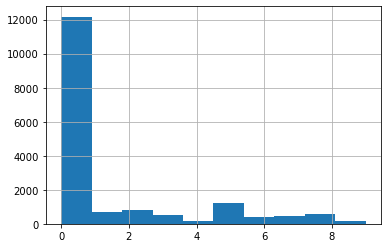

In [24]:
y_train.hist()

Видим, что здоровых людей гораздо больше, чем больных. Чтобы немного уравнять данные, попробуем для начала решить задачу бинарной классификации - здоровый-больной.

In [25]:
X_train = num_pipeline.fit_transform(X_train_raw)
y_train_bin = np.sign(y_train)
y_train.value_counts(), y_train_bin.value_counts()

(0    12171
 5     1221
 2      807
 1      682
 8      593
 3      509
 7      461
 6      422
 4      156
 9      146
 Name: f_label, dtype: int64,
 0    12171
 1     4997
 Name: f_label, dtype: int64)

<AxesSubplot:>

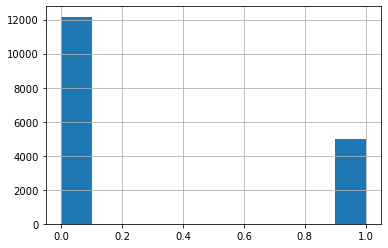

In [26]:
y_train_bin.hist()

Несбалансированность все еще присутствует, однако так стало гораздо лучше.

# 3. Обучение моделей

## 3.1. KNN

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

nnb_small = [1, 2]
nnb_med = [3, 4, 5]
nnb_big = [6, 7, 8, 9]
nnb_large = [10, 12, 14, 15]
names = ['est_small', 'est_med', 'est_big', 'est_large']

knn_clf = KNeighborsClassifier()

estim_dict = {}
for nnb, name in zip([nnb_small, nnb_med, nnb_big, nnb_large], names):
    grid = GridSearchCV(knn_clf, param_grid = {'n_neighbors': nnb}, cv=10)
    grid.fit(X_train, y_train_bin)

    best_cv_err = 1 - grid.best_score_
    best_n_neighbors = grid.best_estimator_.n_neighbors
    estim_dict[name] = grid.best_estimator_
    print(f'{name}: neighb = {best_n_neighbors}, err = {best_cv_err}')

est_small: neighb = 1, err = 0.1903533226625831
est_med: neighb = 3, err = 0.2063720738589696
est_big: neighb = 6, err = 0.22483688414090275
est_large: neighb = 10, err = 0.24336013918133892


In [28]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

for name in names:
    estimator = estim_dict[name]
    y_pred = estimator.predict(X_train)
    print(f'{estimator.n_neighbors:}-nn: Mean = {(y_pred == y_train_bin).mean():.3f},', end=' ') 
    print(f'Precision = {precision_score(y_train_bin, y_pred):.3f},', end=' ')
    print(f' Recall = {recall_score(y_train_bin, y_pred):.3f},', end=' ')
    print(f' F1 = {f1_score(y_train_bin, y_pred):.3f}')
    print(confusion_matrix(y_train_bin, y_pred))
    print()

1-nn: Mean = 1.000, Precision = 1.000,  Recall = 1.000,  F1 = 1.000
[[12171     0]
 [    0  4997]]

3-nn: Mean = 0.913, Precision = 0.880,  Recall = 0.810,  F1 = 0.844
[[11617   554]
 [  947  4050]]

6-nn: Mean = 0.840, Precision = 0.887,  Recall = 0.518,  F1 = 0.654
[[11841   330]
 [ 2409  2588]]

10-nn: Mean = 0.805, Precision = 0.841,  Recall = 0.409,  F1 = 0.550
[[11784   387]
 [ 2955  2042]]



Видим, что на тренировочной выборке лучше всего показывает себя KNN с 1-м ближайшим соседом. Однако это еще ничего не значит - очень возможно переобучение.

In [29]:
X_test_raw = strat_test_set.drop('f_label', axis=1)
y_test = strat_test_set['f_label'].copy()

In [30]:
X_test = num_pipeline.fit_transform(X_test_raw)
y_test_bin = np.sign(y_test)

In [31]:
for name in names:
    estimator = estim_dict[name]
    y_pred = estimator.predict(X_test)
    print(f'{estimator.n_neighbors:}-nn: Mean = {(y_pred == y_test_bin).mean():.3f},', end=' ') 
    print(f'Precision = {precision_score(y_test_bin, y_pred):.3f},', end=' ')
    print(f' Recall = {recall_score(y_test_bin, y_pred):.3f},', end=' ')
    print(f' F1 = {f1_score(y_test_bin, y_pred):.3f}')
    print(confusion_matrix(y_test_bin, y_pred))
    print()

1-nn: Mean = 0.700, Precision = 0.484,  Recall = 0.450,  F1 = 0.466
[[1086  266]
 [ 306  250]]

3-nn: Mean = 0.698, Precision = 0.476,  Recall = 0.376,  F1 = 0.420
[[1122  230]
 [ 347  209]]

6-nn: Mean = 0.723, Precision = 0.564,  Recall = 0.214,  F1 = 0.310
[[1260   92]
 [ 437  119]]

10-nn: Mean = 0.719, Precision = 0.559,  Recall = 0.171,  F1 = 0.262
[[1277   75]
 [ 461   95]]



На тестовой выборке KNN с 1-м ближайшим соседом все еще лучший по F1. Однако факт переобучения налицо. Дисбаланс двух классов все еще слишком высок.

## 3.2. Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier()
forest_clf.fit(X_train, y_train_bin)

RandomForestClassifier()

In [33]:
y_pred = forest_clf.predict(X_train)
print(f'RandomForest: Mean = {(y_pred == y_train_bin).mean():.3f},', end=' ') 
print(f'Precision = {precision_score(y_train_bin, y_pred):.3f},', end=' ')
print(f' Recall = {recall_score(y_train_bin, y_pred):.3f},', end=' ')
print(f' F1 = {f1_score(y_train_bin, y_pred):.3f}')
print(confusion_matrix(y_train_bin, y_pred))

RandomForest: Mean = 1.000, Precision = 1.000,  Recall = 1.000,  F1 = 1.000
[[12171     0]
 [    0  4997]]


In [34]:
y_pred = forest_clf.predict(X_test)
print(f'RandomForest: Mean = {(y_pred == y_test_bin).mean():.3f},', end=' ') 
print(f'Precision = {precision_score(y_test_bin, y_pred):.3f},', end=' ')
print(f' Recall = {recall_score(y_test_bin, y_pred):.3f},', end=' ')
print(f' F1 = {f1_score(y_test_bin, y_pred):.3f}')
print(confusion_matrix(y_test_bin, y_pred))

RandomForest: Mean = 0.714, Precision = 0.559,  Recall = 0.094,  F1 = 0.160
[[1311   41]
 [ 504   52]]


Random Forest показал себя еще хуже KNN. Вряд ли без дополнительных действий с данными тут что-то можно сделать.

## 3.3. Decision Tree

In [35]:
from sklearn.tree import DecisionTreeClassifier

dtc_clf = DecisionTreeClassifier()
dtc_clf.fit(X_train, y_train_bin)

DecisionTreeClassifier()

In [36]:
y_pred = dtc_clf.predict(X_train)
print(f'DecTree: Mean = {(y_pred == y_train_bin).mean():.3f},', end=' ') 
print(f'Precision = {precision_score(y_train_bin, y_pred):.3f},', end=' ')
print(f' Recall = {recall_score(y_train_bin, y_pred):.3f},', end=' ')
print(f' F1 = {f1_score(y_train_bin, y_pred):.3f}')
print(confusion_matrix(y_train_bin, y_pred))

DecTree: Mean = 1.000, Precision = 1.000,  Recall = 1.000,  F1 = 1.000
[[12171     0]
 [    0  4997]]


In [37]:
y_pred = dtc_clf.predict(X_test)
print(f'DecTree: Mean = {(y_pred == y_test_bin).mean():.3f},', end=' ') 
print(f'Precision = {precision_score(y_test_bin, y_pred):.3f},', end=' ')
print(f' Recall = {recall_score(y_test_bin, y_pred):.3f},', end=' ')
print(f' F1 = {f1_score(y_test_bin, y_pred):.3f}')
print(confusion_matrix(y_test_bin, y_pred))

DecTree: Mean = 0.567, Precision = 0.301,  Recall = 0.369,  F1 = 0.331
[[876 476]
 [351 205]]


Decision Tree справился немного лучше, но этого все еще маловато.

## 3.4. Классификация на исходных итоговых классах

Ради интереса посмотрим, что же будет, если попробовать обучиться на всех 10-ти итоговых классах.

In [38]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

KNeighborsClassifier()

In [39]:
knn_clf.score(X_test, y_test)

0.6923480083857443

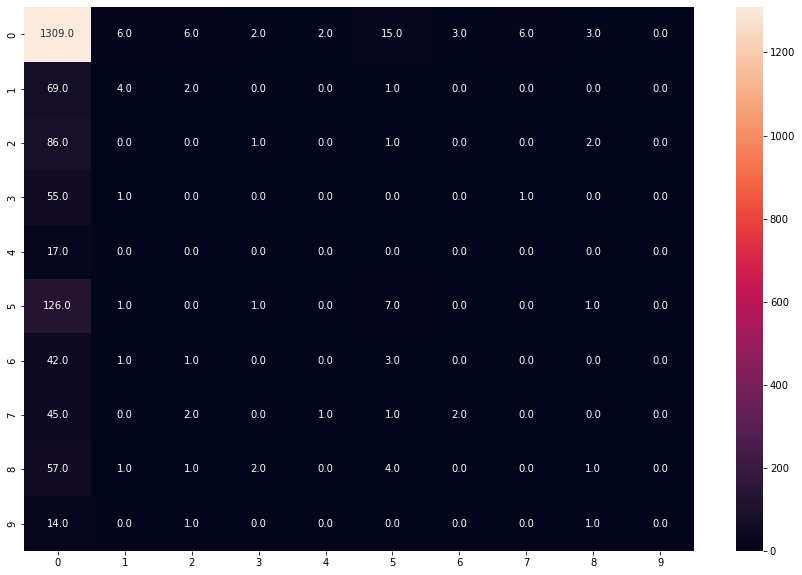

In [40]:
y_test_predict = knn_clf.predict(X_test)
plt.figure(figsize=(15,10))
x=sns.heatmap(confusion_matrix(y_test, y_test_predict), annot=True, fmt='0.1f')
plt.show()

Из-за тотального превосходства первого класса модель относит практически любые данные к нему.

In [41]:
forest_clf = RandomForestClassifier()
forest_clf.fit(X_train, y_train)

RandomForestClassifier()

In [42]:
forest_clf.score(X_test, y_test)

0.7091194968553459

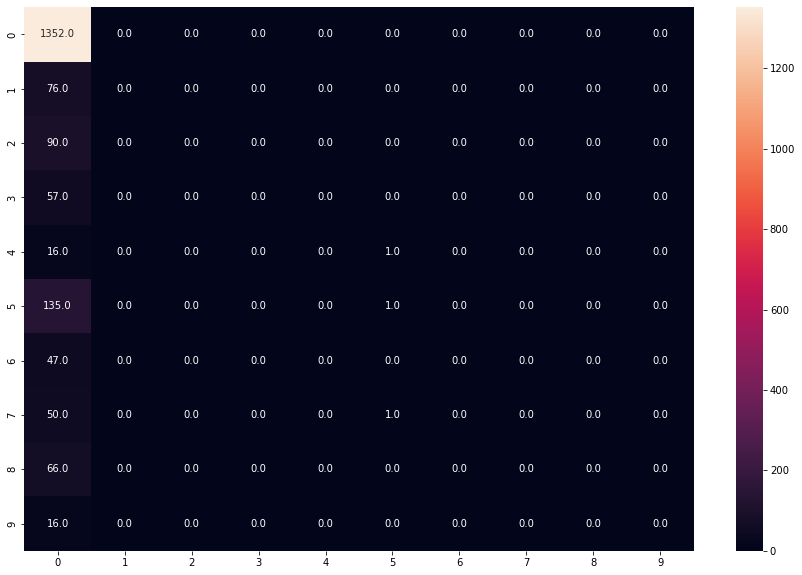

In [43]:
y_test_predict = forest_clf.predict(X_test)
plt.figure(figsize=(15,10))
sns.heatmap(confusion_matrix(y_test, y_test_predict), annot=True, fmt='0.1f')
plt.show()

Random Forest не лучше.